In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import dataset

In [84]:
df = pd.read_csv('/Users/supisara/Desktop/ML dataset/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Convert booleans to binary and ensure categorical consistency
df['Revenue'] = df['Revenue'].astype(int)
df['Weekend'] = df['Weekend'].astype(int)
df['VisitorType'] = df['VisitorType'].astype(str)

# Separate features and target variable
X = df.drop(columns='Revenue')
y = df['Revenue']

# Specify categorical and numerical columns
categorical_cols = ['Month', 'VisitorType']
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.drop(['Weekend']).tolist()

# Define preprocessing pipeline: scale numeric features and encode categorical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

### Split data into train and final holdout test set

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Random Forest

In [11]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Build the final Random Forest pipeline
final_rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
final_rf_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = final_rf_pipeline.predict(X_test)
y_proba_rf = final_rf_pipeline.predict_proba(X_test)[:, 1]


# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Print Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Print ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      2084
           1       0.64      0.68      0.66       382

    accuracy                           0.89      2466
   macro avg       0.79      0.80      0.80      2466
weighted avg       0.89      0.89      0.89      2466

Confusion Matrix:
 [[1936  148]
 [ 122  260]]
ROC-AUC Score: 0.9211877330144407


### Confusion Matrix & ROC Curve Plot - Random Forest

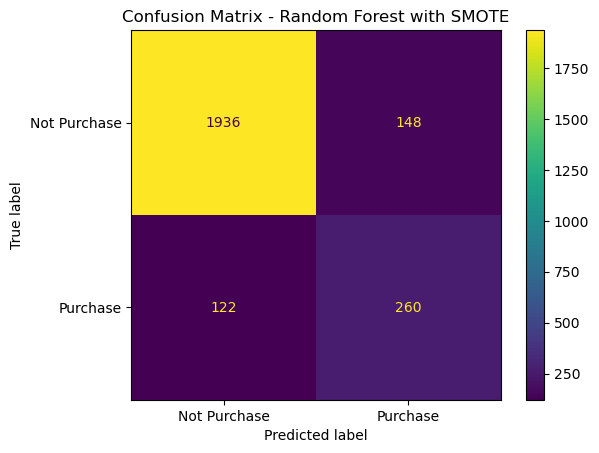

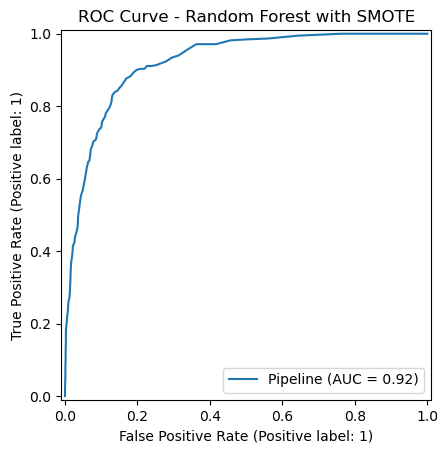

In [21]:
# Plot Random Forest confusion matrix
ConfusionMatrixDisplay.from_estimator(final_rf_pipeline, X_test, y_test, 
                                    display_labels=['Not Purchase', 'Purchase'])
plt.title("Confusion Matrix - Random Forest with SMOTE")
plt.show()

# Plot Random Forest ROC curve
RocCurveDisplay.from_estimator(final_rf_pipeline, X_test, y_test)
plt.title("ROC Curve - Random Forest with SMOTE")
plt.show()

### Random Forest - Feature Importance

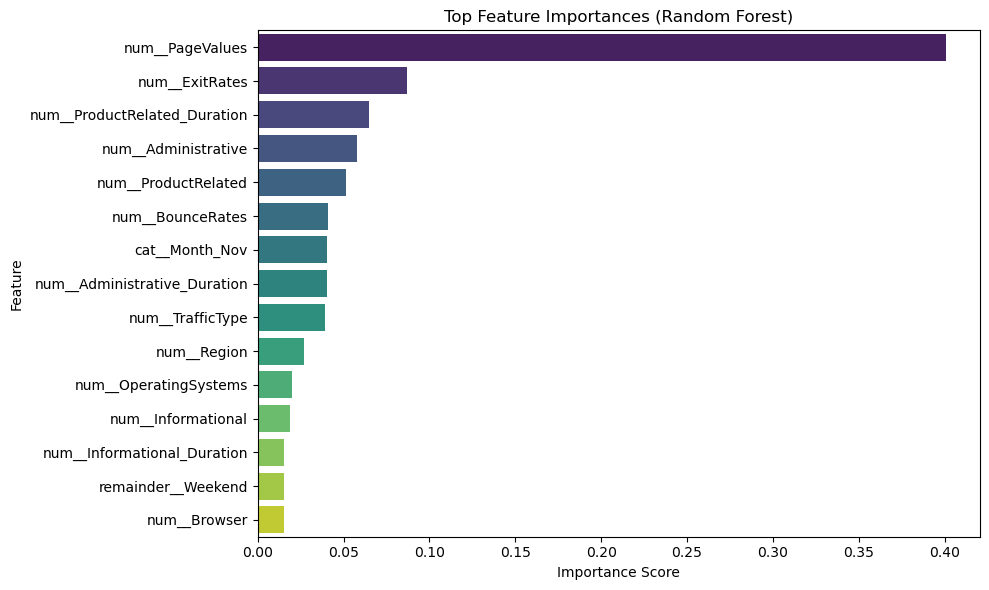

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the trained Random Forest model from the pipeline
rf_model = final_rf_pipeline.named_steps['classifier']

# Get feature names
feature_names = final_rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extract feature importances
importances = rf_model.feature_importances_

# Create a dataframe for visualisation
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top features
top_n = 15
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), hue='Feature', palette='viridis', legend=False)
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### XGBoost

In [54]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

# Build the Final XGBoost Pipeline
final_xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        eval_metric='logloss',
        random_state=42
    ))
])

# Fit the Model
final_xgb_pipeline.fit(X_train, y_train)

# Predict on the Test Set
y_pred_xgb = final_xgb_pipeline.predict(X_test)
y_proba_xgb = final_xgb_pipeline.predict_proba(X_test)[:, 1]

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Print Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# Print ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      2084
           1       0.66      0.61      0.63       382

    accuracy                           0.89      2466
   macro avg       0.80      0.78      0.79      2466
weighted avg       0.89      0.89      0.89      2466

Confusion Matrix:
 [[1965  119]
 [ 149  233]]
ROC-AUC Score: 0.9217247339490108


### Confusion Matrix & ROC Curve Plot - XGBoost

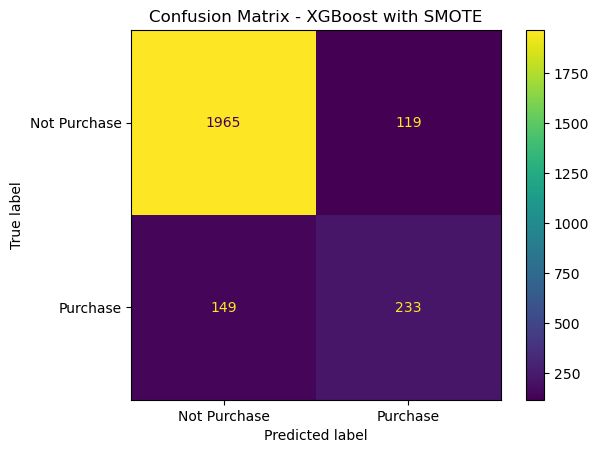

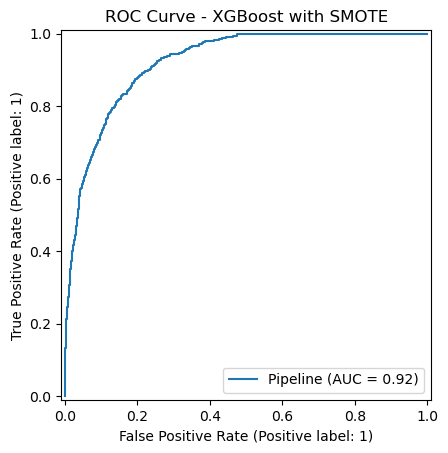

In [82]:
# Plot XGBoost confusion matrix
ConfusionMatrixDisplay.from_estimator(final_xgb_pipeline, X_test, y_test, 
                                      display_labels=['Not Purchase', 'Purchase'])
plt.title("Confusion Matrix - XGBoost with SMOTE")
plt.show()

# Plot XGBoost ROC curve
RocCurveDisplay.from_estimator(final_xgb_pipeline, X_test, y_test)
plt.title("ROC Curve - XGBoost with SMOTE")
plt.show()

### ROC Curve Comparision (Random Forest vs XGBoost)

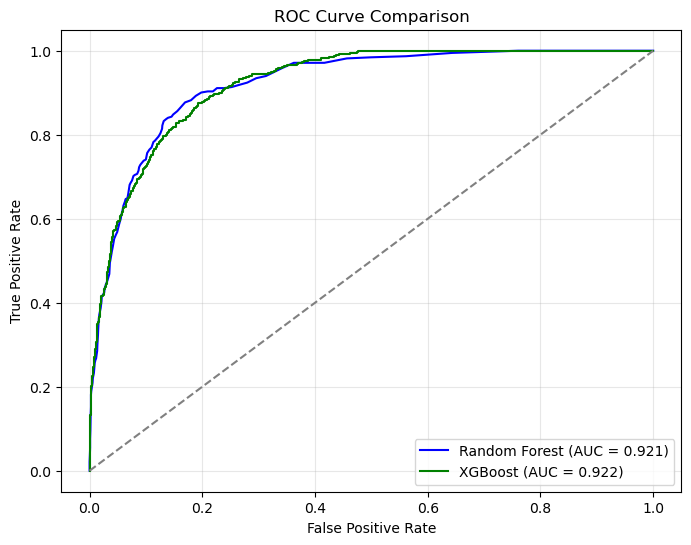

In [78]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves and AUCs
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Baseline

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()